# Background

A clinical trial is a structured research study designed to evaluate the safety and effectiveness of medical treatments or interventions. During these trials, all **adverse events** experienced by patients are recorded, along with their **grades** (severity levels) and the **time of each grade change**.

Before Epic, AE records were documented in `CRR/eSource`. The data entry approach differs between `CRR/eSource` and `EPIC`, and the set of available columns is not the same across systems. As a result, there are differences in both the **data structure** and the **columns recorded**.

<p style="color:#7EAEDC; font-size:16px; font-weight:600; margin-bottom:6px;">
🔵 <strong>Data Entry Approaches in</strong> <code style="font-weight:400;">CRR/eSource</code> <strong>and</strong> <code style="font-weight:400;">EPIC</code>
</p>

1. `CRR/eSource`: For each grade change, a new row was created.  
2. `EPIC`: It was expected that nurses would follow the same approach as in `CRR/eSource`. However, `EPIC`, as part of the foundation system, includes a feature that allows frontline staff to enter grade changes directly for a specific event. When they do so, `EPIC` logs only the start date of the new grade, assuming the end date of the previous grade is the start date of the next one. This approach is generally preferred by frontline staff. 

---

<p style="color:#7EAEDC; font-size:16px; font-weight:600; margin-bottom:6px;">
🔵 <strong>Notes on Missing Dates in</strong> <code style="font-weight:400;">CRR/eSource</code> <strong>and</strong> <code style="font-weight:400;">EPIC</code>
</p>

1. `CRR/eSource`: they were allowed to use 'unknown' for the day, month, and year when uncertain about
any of the date fields, allowing more flexibility in documentation. When using the data, they
would then apply sponsor-defined rules to handle such cases.
2. `EPIC`: the 'unknown' option is not available, so when uncertain about the day, the current
approach is to select the 1st as a placeholder in these cases.

---

<p style="color:#7EAEDC; font-size:16px; font-weight:600; margin-bottom:6px;">
🔵 <strong>Notes on</strong> <code style="font-weight:400;">ae_resolved_date</code> <strong>,</strong> <code style="font-weight:400;">current_grade</code> <strong>, and</strong> <code style="font-weight:400;">ae_highest_grade</code> 
</p>

In `EPIC`, the **ae_resolved_date** corresponds to the **end date of the last grade** in the `ae_grade` column.  
However, the resolve date was **not recorded** in two cases:

1. If the event was still ongoing when the patient left the study — the adverse event remained **unresolved**, as leaving did not imply resolution.  
2. If the patient **passed away**, the adverse event also remained **unresolved**.


Furthermore, a few patients have both a `current_grade` and a `ae_resolved_date`, which seems inconsistent. Typically, once an adverse event is resolved, the **current grade** should be blank in the extracted data.  

Also, the `ae_highest_grade` column represents the **highest grade** the patient experienced during the trial. 

---

<p style="color:#7EAEDC; font-size:16px; font-weight:600; margin-bottom:6px;">
🔵 <strong>Notes on</strong> <code style="font-weight:400;">ae_category</code> <strong>Column</strong>
</p>


1. `CRR/eSource`: versions **3**, **4**, and **5** of **CTCAE** were used.  
The format of the `ae_category` column was adjusted to distinguish between these versions:

| CTCAE Version | Formatting Style         | Example     |
|----------------|--------------------------|--------------|
| **v3**         | ALL UPPERCASE            | `CARDIAC DISORDERS`   |
| **v4**         | lowercase, no period     | `cardiac disorders`   |
| **v5**         | lowercase, with a period | `cardiac disorders.`  |

2. `EPIC`: only versions 4 or 5 are used.

---

<p style="color:#7EAEDC; font-size:16px; font-weight:600; margin-bottom:6px;">
🔵 <strong>Notes on</strong> <code style="font-weight:400;">treatment_required</code> <strong>and</strong> <code style="font-weight:400;">sae</code> <strong>Columns</strong>
</p>

We should **avoid using** the `treatment_required` and `sae` columns,  
as they were **optional fields** and therefore **not reliable** indicators.

- Staff do **not** use `CRR/eSource` or `EPIC` to track **Serious Adverse Events (SAEs)**.  
- SAEs are recorded through a **separate process** using:  
  - a sponsor-provided SAE reporting form, or  
  - an investigator-initiated SAE form.  
- These forms are **paper-based** and capture additional details required for SAE documentation.  

One limitation of `EPIC` is that its **data entry logic cannot be modified**,  
so optional fields cannot be made mandatory — and `sae` is one such **non-mandatory** field.  

Based on protocol requirements, certain **grade 4 or 5 AEs** should be classified as SAEs,  
but in practice, staff may **not have checked the SAE box** to indicate this.

While staff are responsible for recording all AEs, **SAEs are protocol-specific**.  
This means there are instances where a **grade 4 or 5 event** does *not* need to be recorded as an SAE,  
depending on the protocol. Conversely, there are cases where a **grade 2 event**  
*does* meet the criteria for SAE reporting.  

Over time, the **standards for what qualifies as an SAE** have also evolved,  
adding further variability to how these events are recorded.

# Imports and setups

In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandasql as ps
import textwrap
from math import ceil
from matplotlib.patches import Patch

In [ ]:
from src.constants import (
    crr_cols_mapping,
    ae_term_corrections,
    epic_cols_mapping,
    month_mapping,
    cols_of_interest
)

from src.queries import (
    ct_epic_query,
    ct_crr_query
)

In [ ]:
# Set the maximum number of columns/rows to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

# Clinical trials data - CRR/eSource

## Read data

In [ ]:
# Define the file path for the CRR dataset
crr_path='/cluster/home/t128190uhn/datasets/clinical_trials/raw/ctcae_original_crr.xlsx'

In [ ]:
# Load the 'CRR' sheet into a DataFrame
ct_crr = pd.read_excel(crr_path, sheet_name='CRR')

## Quick prep and cleanup

In [ ]:
# Report and drop duplicates
print("\nTotal duplicate rows:", ct_crr.duplicated().sum())
ct_crr = ct_crr.drop_duplicates()

In [ ]:
# Drop empty columns, if any
print(f"✅ Dropped empty columns: {empty_cols}" if (empty_cols := [c for c in ct_crr.columns if ct_crr[c].isna().all()]) else "✅ There were no empty columns to drop.") or ct_crr.drop(columns=empty_cols, inplace=True)

In [ ]:
# Rename and reorder columns
ct_crr = ct_crr.rename(columns=crr_cols_mapping)[list(crr_cols_mapping.values())]

## Clean column values

### 'age_at_enrolment'

Several rows with negative `age_at_enrolment` values were found. This issue occurred because `age_at_enrolment` was calculated using the formula: `enrolled_date - birthdate`. In these records, the `enrolled_date` is incorrect (it even precedes the `study_activation_date`).

To resolve this issue, `age_at_enrolment` should be recalculated using the formula: `study_activation_date` - `birthdate`.

In [ ]:
# Identify rows where the recorded age is negative
mask = ct_crr['age_at_enrolment'] < 0

# Recalculate age for those rows using study activation date instead of enrolled date
ct_crr.loc[mask, 'age_at_enrolment'] = (
    (ct_crr.loc[mask, 'study_activation_date'] - ct_crr.loc[mask, 'birthdate'])
    .dt.days / 365.25
)

### 'investigator_initiated'

In [ ]:
# Convert 'investigator_initiated' from categorical ('Y'/'N'/<NA>) to nullable boolean (True/False/<NA>) while preserving missing values as NaN
ct_crr['investigator_initiated'] = (
    ct_crr['investigator_initiated'].map({'Y': True, 'N': False}).astype('boolean')
)

### 'ctcae_version'

In [ ]:
# Remove rows where 'ctcae_version' is incorrectly recorded as 'Ver 4Ver 3'
ct_crr.drop(ct_crr[ct_crr["ctcae_version"] == 'Ver 4Ver 3'].index, inplace=True)

In [ ]:
# Define a mapping from version strings to numeric values
version_map = {'Ver 3': 3, 'Ver 4': 4, 'Ver 5': 5}

# Map CTCAE versions to integers
ct_crr['ctcae_version'] = ct_crr['ctcae_version'].map(version_map).astype('Int64')

### 'ae_grade_start_date'

Based on the explorations, `ae_grade_start_date` caused duplicates in records. For example:

In [ ]:
# Example showing how 'ae_grade_start_date' created duplicate records
ct_crr.loc[[72,77], ['ae_term', 'ae_grade','ae_grade_start_date', 'ae_grade_start_date_day', 'ae_grade_start_date_month', 'ae_grade_start_date_year' ]]

#### Drop 'ae_grade_start_date' column

It was verified that removing the `ae_grade_start_date` column would not result in the loss of any information that could not be reconstructed from the `ae_grade_start_date_day`, `ae_grade_start_date_month`, and `ae_grade_start_date_year` columns. Therefore, the column will first be dropped, duplicate records will then be removed, and finally, the column will be reconstructed from the date components to resolve the issue of duplicate records.

In [ ]:
# Remove 'ae_grade_start_date' column and drop duplicate records
initial_count = ct_crr.shape[0]
ct_crr = ct_crr.drop(columns=['ae_grade_start_date']).drop_duplicates().reset_index(drop=True)
final_count = ct_crr.shape[0]

# Report how many were removed
print(f"✅ {initial_count - final_count} duplicate records were removed after dropping the 'ae_grade_start_date' column.")

#### Reconstruct 'ae_grade_start_date' column

In [ ]:
# Count and print the number of records
# Where each AE start date component (day, month, year) is marked as 'Unknown'
for col in ['ae_grade_start_date_day', 'ae_grade_start_date_month', 'ae_grade_start_date_year']:
    missing_count = (ct_crr[col] == 'Unknown').sum()
    print(f"Number of records with missing {col.split('_')[-1]}: {missing_count}")

Plan for Handling Missing Values

- Missing **day** values will be imputed with **15**, as this choice minimizes the average deviation from the actual day.  
- Missing **month** and **year** values will **not** be imputed; records with these missing components will be **dropped** from the dataset.


In [ ]:
# Rebuild 'ae_grade_start_date' from components
# Impute missing days with 15 and skipping rows with unknown month/year
ct_crr['ae_grade_start_date'] = pd.to_datetime(ct_crr.apply(
    lambda row: np.nan if 'Unknown' in [row['ae_grade_start_date_month'], row['ae_grade_start_date_year']]
    else f"{row['ae_grade_start_date_year']}-{month_mapping.get(row['ae_grade_start_date_month'], np.nan)}-{row['ae_grade_start_date_day'] if row['ae_grade_start_date_day'] != 'Unknown' else '15'}",
    axis=1), errors='coerce')

In [ ]:
# Take a look at different possible records
ct_crr.loc[[1,7,9,18836], ['ae_grade_start_date_day', 'ae_grade_start_date_month', 'ae_grade_start_date_year', 'ae_grade_start_date']]

In [ ]:
# Drop rows with NaT in 'ae_grade_start_date' and print how many were removed
before = ct_crr.shape[0]
ct_crr.dropna(subset=['ae_grade_start_date'], inplace=True)
after = ct_crr.shape[0]
print(f"✅ Removed {before - after} records with NaT in 'ae_grade_start_date'.")

### 'ae_grade_end_date'

In [ ]:
# Define create_standard_date function
def create_standard_date(row):
    day = row['ae_grade_end_date_day']
    month = row['ae_grade_end_date_month']
    year = row['ae_grade_end_date_year']
    
    # Check for valid day, month, and year
    if pd.notnull(day) and pd.notnull(month) and pd.notnull(year):
        # Check if the values are 'Unknown'
        if day != 'Unknown' and month in month_mapping:
            try:
                # Convert to datetime
                return pd.to_datetime(f"{int(year)}-{month_mapping[month]}-{int(day)}", errors='raise')
            except ValueError:
                return pd.NaT
        else:
            return pd.NaT
    else:
        return pd.NaT

In [ ]:
# Apply the function to create the ae_grade_end_date
ct_crr['ae_grade_end_date'] = ct_crr.apply(create_standard_date, axis=1)

In [ ]:
# Take a look at different possible records
ct_crr.loc[[20,17,175, 8729, 155], ['ae_grade_end_date_day', 'ae_grade_end_date_month', 'ae_grade_end_date_year', 'ae_grade_end_date']]

## Value mapping

As shown in the following Venn diagram, nearly half of the MedDRA codes used in version 3 (509 out of 1,059) do not appear in the subsequent versions; many were merged, split, or removed. 

However, the changes from version 4 to version 5 were relatively minor (777 of the 837 unique codes in v5 were identical to those in v4, with only 60 codes modified). So, mapping v4 to v5 is unlikely to result in significant information loss.

That's why for this study, we decided to exclude v3-coded records from the main analysis.

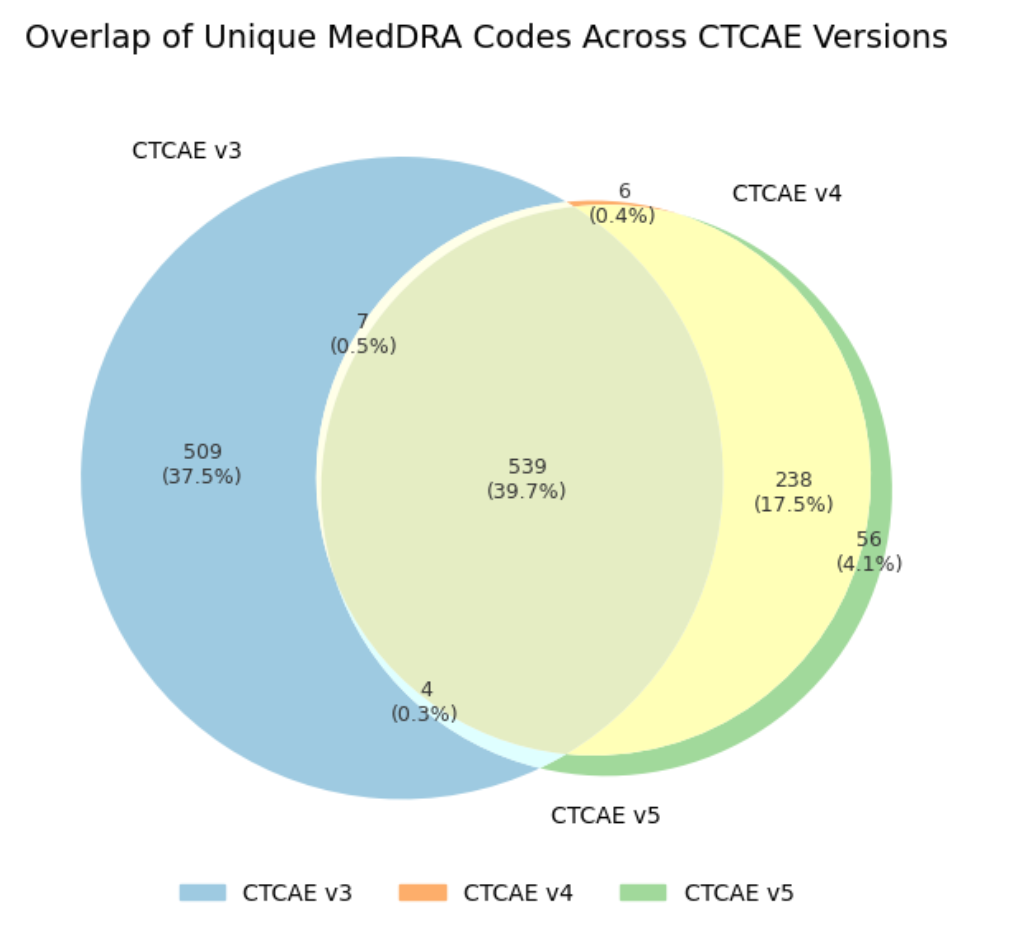

#### Detect CTCAE version

In [ ]:
# Detect CTCAE version from 'ae_category' formatting and store result in a new column
def detect_ctcae_version(text):
    if pd.isna(text):
        return None
    text_str = str(text).strip()
    if text_str.isupper():
        return 3
    elif text_str.endswith('.'):
        return 5
    else:
        return 4

ct_crr['detected_ctcae_version'] = ct_crr['ae_category'].apply(detect_ctcae_version)

In [ ]:
# Cross-tab of reported vs detected CTCAE versions
pd.crosstab(ct_crr['ctcae_version'], ct_crr['detected_ctcae_version'])

#### Remove records

After manual review, the detected version (based on formatting) was found to be more accurate than the recorded one. Therefore, all entries with detected version 3 should be removed.

In [ ]:
# Define mask for rows to drop
mask = ct_crr['detected_ctcae_version'] == 3

# Count totals before and after, grouped by AE grade category (<3 vs ≥3)
def grade_counts(df):
    return pd.Series({
        '<3': (df['ae_grade'] < 3).sum(),
        '≥3': (df['ae_grade'] >= 3).sum(),
        'Total': len(df)
    })

before = grade_counts(ct_crr)
dropped = grade_counts(ct_crr[mask])
after = grade_counts(ct_crr[~mask])

# Drop rows
ct_crr = ct_crr[~mask]

# Combine into one summary table
summary = pd.DataFrame([before, dropped, after], index=['Before', 'Dropped', 'After'])
print(summary)

#### Standardize AE term spellings and capitalization

In [ ]:
# Correct typographical and capitalization inconsistencies in the 'ae_term' column
# to ensure uniform term representation
ct_crr['ae_term'] = ct_crr['ae_term'].replace(ae_term_corrections)

#### Read lookup tables

In [ ]:
# Define the file path for the CTCAE mappings dataset
# Read the specific sheet and filter out rows where v4_grade_or_definition == 'Definition'
v4_grade_to_v5_grade = (
    pd.read_excel('/cluster/home/t128190uhn/datasets/ctcae/raw/ctcae_mappings.xlsx', sheet_name='v4_grade_to_v5_grade')
    .query("v4_grade_or_definition != 'Definition'")
)

ctcae_v5 = pd.read_parquet("/cluster/home/t128190uhn/datasets/ctcae/cleaned/unpivoted_ctcae_v5.parquet")

In [ ]:
# - For v4 records: join with v4→v5 lookup
# - For v5 records: join with ctcae_v5 to add SOC info
# Combine both parts (UNION ALL) into one dataframe
mapped_ct_crr = ps.sqldf(ct_crr_query, locals())

## Data shape

In [ ]:
# Describe the dataframe
print("DataFrame shape:", mapped_ct_crr.shape)

## Missing values

In [ ]:
# Compute missing counts and percentages
ct_crr_missing_counts = mapped_ct_crr.isnull().sum()
ct_crr_missing_perc = (ct_crr_missing_counts / len(mapped_ct_crr) * 100).round(1)

# Combine into a single DataFrame
ct_crr_missing_sorted = (
    pd.DataFrame({
        'missing_count': ct_crr_missing_counts,
        'missing_percent': ct_crr_missing_perc
    })
    .query("missing_count > 0")  # exclude columns with no missing values
    .sort_values('missing_count', ascending=False)
)

print("Missing values per column (sorted, excluding columns with no missing):")
display(ct_crr_missing_sorted)


All records with a value in `ae_specific` were recorded based on CTCAE version 3. No specifics were captured for versions 4 or 5, which is problematic because several terms ending with “Other – specify” represent multiple distinct specifics. Without this information, aggregating them results in a loss of detail.

## Save cleaned dataset

In [ ]:
# Save the cleaned CRR dataset in Parquet format
mapped_ct_crr.to_parquet("/cluster/home/t128190uhn/datasets/clinical_trials/cleaning/ct_crr.parquet")

# Clinical trials data - EPIC

## Read data

In [ ]:
# Define the file path for the EPIC dataset
epic_path='/cluster/home/t128190uhn/datasets/clinical_trials/raw/ctcae_original_epic.xlsx'

In [ ]:
# Load the 'epic' sheet into a DataFrame
ct_epic = pd.read_excel(epic_path, sheet_name='epic')

## Quick prep and cleanup

In [ ]:
# Report and drop duplicates
print("\nTotal duplicate rows:", ct_epic.duplicated().sum())
ct_epic = ct_epic.drop_duplicates()

In [ ]:
# Drop empty columns, if any
print(f"✅ Dropped empty columns: {empty_cols}" if (empty_cols := [c for c in ct_epic.columns if ct_epic[c].isna().all()]) else "✅ There were no empty columns to drop.") or ct_epic.drop(columns=empty_cols, inplace=True)

In [ ]:
# Rename and reorder columns
ct_epic = ct_epic.rename(columns=epic_cols_mapping)[list(epic_cols_mapping.values())]

## Row explosion

In [ ]:
# Before row explosion
ct_epic[['ae_grade', 'ae_grade_start_date']].head(1)

In [ ]:
# Expand rows where 'ae_grade' and 'ae_grade_start_date' contain multiple values separated by '\n',
# creating one row per grade/start-date pair while keeping other columns unchanged

ct_epic = (
    ct_epic
    .assign(
        ae_grade=ct_epic['ae_grade'].astype(str).str.split('\n'),
        ae_grade_start_date=ct_epic['ae_grade_start_date'].astype(str).str.split('\n')
    )
    .explode(['ae_grade', 'ae_grade_start_date'])
    .reset_index(drop=True)
)

In [ ]:
# After row explosion
ct_epic[['ae_grade', 'ae_grade_start_date']].head(4)

## Data shape

In [ ]:
# Describe the dataframe
print("DataFrame shape:", ct_epic.shape)

## Clean column values

### 'ae_grade_start_date'

✅ Info:

Rows with / are in dd/mm/yyyy format.

Rows with - are in yyyy-mm-dd format.

✅ Therefore:

It’s safe to parse / rows with dayfirst=True.

It’s safe to parse - rows with dayfirst=False (standard ISO date).

In [ ]:
# Define a function to parse each date correctly based on separator
def parse_mixed_date(val):
    val_str = str(val)
    if '/' in val_str:
        return pd.to_datetime(val_str, dayfirst=True, errors='coerce')  # Slash ⇒ dd/mm/yyyy
    elif '-' in val_str:
        return pd.to_datetime(val_str, dayfirst=False, errors='coerce')  # Dash ⇒ yyyy-mm-dd
    else:
        return pd.to_datetime(val_str, errors='coerce')  # Catch-all fallback

# Apply the parsing function to the 'ae_grade_start_date' column
ct_epic['ae_grade_start_date'] = ct_epic['ae_grade_start_date'].apply(parse_mixed_date)

### 'ae_grade'

In [ ]:
# Extract numbers in brackets and convert AE grade columns to nullable integers
for col in ['ae_grade', 'ae_current_grade', 'ae_highest_grade']:
    ct_epic[col] = ct_epic[col].astype(str).str.extract(r"\[(\d+)\]").astype("Int64")

### 'investigator_initiated'

In [ ]:
# Convert 'investigator_initiated' from categorical ('Yes'/'No'/<NA>) to nullable boolean (True/False/<NA>) while preserving missing values as NaN
ct_epic['investigator_initiated'] = (
    ct_epic['investigator_initiated'].map({'Yes': True, 'No': False}).astype('boolean')
)

### 'phase'

In [ ]:
# Clean 'phase' values: remove colons and replace 'Phase N/A' with NaN
ct_epic['phase'] = (
    ct_epic['phase']
    .astype(str)
    .str.replace(':', '', regex=False)
    .replace('Phase N/A', np.nan)
)

## Mapping values

In [ ]:
# - For v5 records: join with ctcae_v5 to add SOC info
# - For v4 records: join with v4→v5 lookup
# Combine both parts (UNION ALL) into one dataframe
mapped_ct_epic = ps.sqldf(ct_epic_query, locals())

## Missing values

In [ ]:
# Compute missing counts and percentages
ct_epic_missing_counts = ct_epic.isnull().sum()
ct_epic_missing_perc = (ct_epic_missing_counts / len(ct_epic) * 100).round(1)

# Combine into a single DataFrame
ct_epic_missing_sorted = (
    pd.DataFrame({
        'missing_count': ct_epic_missing_counts,
        'missing_percent': ct_epic_missing_perc
    })
    .query("missing_count > 0")  # exclude columns with no missing values
    .sort_values('missing_count', ascending=False)
)

print("Missing values per column (sorted, excluding columns with no missing):")
display(ct_epic_missing_sorted)


## Save cleaned dataset

In [ ]:
# Save the cleaned EPIC dataset in Parquet format
mapped_ct_epic.to_parquet("/cluster/home/t128190uhn/datasets/clinical_trials/cleaning/ct_epic.parquet")

# Data Integration (CRR/eSource + EPIC)

## Append datasets

In [ ]:
# Add a source column and align columns; missing ones become <NA>
cols_all = cols_of_interest + ['source']

ct_crr_sel  = (mapped_ct_crr
               .assign(source='crr')
               .reindex(columns=cols_all)
               .dropna(axis=1, how='all')
)

ct_epic_sel = (mapped_ct_epic
               .assign(source='epic')
               .reindex(columns=cols_all)
               .dropna(axis=1, how='all')
)               

# Append (row-bind) into a single dataframe
ct = pd.concat([ct_crr_sel, ct_epic_sel], ignore_index=True)

## Drop duplicates

In [ ]:
# Remove duplicate records
print("\nTotal duplicate rows:", ct.duplicated().sum())
ct_unique = ct.drop_duplicates()

### Remove grade 0 events

In [ ]:
# Count and remove records with ae_grade equal to 0
n_removed = (ct['ae_grade'] == 0).sum()
print(f"Number of records that will be removed: {n_removed}")

ct = ct[ct['ae_grade'] != 0]

### Remove outlier dates

In [ ]:
date_cols = ["birthdate", "ae_grade_start_date"]

for col in date_cols:
    if col in ct.columns:
        ct[col] = pd.to_datetime(ct[col], errors="coerce")

In [ ]:
# Count records to be removed
n_removed = (ct['ae_grade_start_date'].dt.year < 2013).sum()
print(f"Number of records that will be removed: {n_removed}")

# Create a filtered copy
ct = ct[ct['ae_grade_start_date'].dt.year >= 2013]

### Remove events grade 1 or 2

In [ ]:
# Count records that will be removed (grade 1 or 2)
n_removed = ct['ae_grade'].isin([1, 2]).sum()
print(f"Number of records that will be removed: {n_removed}")

# Keep only grades higher than 2
ct_high_grades = ct[~ct['ae_grade'].isin([1, 2])].copy()

## Save integrated dataset

In [ ]:
# Save outputs as Parquet files
ct.to_parquet("/cluster/home/t128190uhn/datasets/clinical_trials/cleaning/ct.parquet", index=False)
ct_high_grades.to_parquet("/cluster/home/t128190uhn/datasets/clinical_trials/cleaning/ct_high_grades.parquet", index=False)

# Notes to self 

📝 The format of names in `primary_investigator` differs between `crr` and `epic`.

📝 The columns `birthdates`, `disease_location`, `ctcae_version`, and `ae_category` are present in the `crr` data but missing in the `epic` sheet. The `research_study` column in `epic` is also empty — it’s unclear whether this information was not recorded in `epic` or omitted during the data pull.

📝 Sanity check.

# Questions

⁉️ I need to examine the time intervals between adverse event (AE) occurrence dates for each patient within each study to identify potential outlier dates.

⁉️ Should I exclude patients whose disease site is recorded as 'UHN-COVID-19'?
Disease location -> study

⁉️ I came across several records in Epic where the AE grade is recorded as 0. I assume it means the adverse event did not occur or the patient was at normal baseline for that symptom. Could you please confirm if this interpretation is correct, or if Grade 0 has a different meaning in this context? Example

⁉️ How can we identify baseline events?

⁉️ How can baseline events be accurately identified and excluded?

Change types